Import packages

In [1]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import json
import seaborn as sns
from collections import Counter
import nltk
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

C:\Users\owltu\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\owltu\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [3]:
yelp = pd.read_csv("yelp_balanced.csv")
yelp.head()

,Unnamed: 0,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,111089,S3r97tHMkzR4O-tiIIzwOQ,r0GLQAawvHXUd-xZow-fWQ,mzREMIknfmagJugibXrCsQ,4,2017-04-14,"Food is tasty, it's usually busy, but there al...",0,0,0
1,674606,lZTYcQXntUsLptcWCqyhmg,bDs5_ek9esUkgxFm1jFxfg,aZG9Hp8fdgzq37iuB1QTYg,1,2017-10-01,Probably one of the worst experiences I've eve...,1,0,0
2,3329480,sStohXbOEdPyrutK3zJSmg,mus1d8cMxuEJmP0zfV19hg,I4Nr-MVc26qWr08-S3Q1ow,4,2017-01-19,I was looking for a place to grab a quick bite...,0,0,0
3,3641542,Pvw7lbeyGGLVALvK0DwgDA,qrwH8z4nNUabqlsnwNoDCg,vAbRNF0hJt91oCUpm_sdKw,3,2014-01-09,"Meh, fish was a bit rubbery for $34 swordfish....",1,0,0
4,2054056,XWN8BVvLwcmgEW6xZuOKpg,cYvO88wNlRc_gd03caBZ7Q,sNVGdeOPeitJ3OWUQBINzQ,4,2012-02-29,I've heard so much about this place.. and I mu...,2,2,3


In [71]:
#Clean data to make lowercase, remove special characters, and numbers
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    return df

yelp = clean_text(yelp, 'text', 'text_clean')

In [5]:
yelp_basic = yelp[['stars', 'text_clean']]
yelp_features = yelp[['stars', 'text_clean', 'useful', 'funny', 'cool']]

In [6]:
#Split into train / test datasets -- 20% test
df_train_raw, df_test = train_test_split(yelp_features, test_size=0.2, 
                                         random_state=42, shuffle=True)
df_train_raw, df_dev = train_test_split(df_train_raw, test_size=0.2,
                                        random_state=42, shuffle=True)

df_train = df_train_raw

In [7]:
#Fcn to extract features using TF-IDF vectorizer

def extract_features(df_train, df_dev, df_test, df_extra):
    vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
    x_train = vectorizer.fit_transform(df_train.loc[:, 'text_clean'].values.astype('U'))
    x_dev = vectorizer.transform(df_dev.loc[:, 'text_clean'].values.astype('U'))
    x_test = vectorizer.transform(df_test.loc[:, 'text_clean'].values.astype('U'))
    y_train = df_train.loc[:, 'stars'].tolist()
    y_dev = df_dev.loc[:, 'stars'].tolist()
    y_test = df_test.loc[:, 'stars'].tolist()
    
    #Below section randomly removes 20% of words
    df_extra["text_clean_backup"] = df_extra["text_clean"].values
    import random
    for ix, review in enumerate(df_extra["text_clean"].values):
        r = review.split()
        for i in range(0, len(r)//5): #20 % of words
            r.pop(random.randrange(len(r)))
        df_extra["text_clean"].values[ix] = " ".join(r)

    x_contra = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['contradictory'] == 1].values.astype('U'))
    y_contra = df_extra.loc[:, 'stars'][df_extra['contradictory'] == 1].tolist()
    
    x_figurative = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['figurative'] == 1].values.astype('U'))
    y_figurative = df_extra.loc[:, 'stars'][df_extra['figurative'] == 1].tolist()

    x_qual = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['qualifier'] == 1].values.astype('U'))
    y_qual = df_extra.loc[:, 'stars'][df_extra['qualifier'] == 1].tolist()

    
    return x_train, x_dev, x_test, x_contra, x_figurative, x_qual, y_train, y_dev, y_test, y_contra, y_figurative, y_qual

In [22]:
#Fcn to extract features using TF-IDF vectorizer for jsut edge cases
def short_extract(df_extra):
    vectorizer = TfidfVectorizer(analyzer='word', 
                               stop_words='english',
                               ngram_range=(1, 2),
                               lowercase=True,
                               min_df=5,
                               binary=False)
    x_train = vectorizer.fit_transform(df_train.loc[:, 'text_clean'].values.astype('U'))
    
    #Below section randomly removes 20% of words
    df_extra["text_clean_backup"] = df_extra["text_clean"].values
    import random
    for ix, review in enumerate(df_extra["text_clean"].values):
        r = review.split()
        for i in range(0, len(r)//5): #20 % of words
            r.pop(random.randrange(len(r)))
        df_extra["text_clean"].values[ix] = " ".join(r)

    x_contra = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['contradictory'] == 1].values.astype('U'))
    y_contra = df_extra.loc[:, 'stars'][df_extra['contradictory'] == 1].tolist()
    
    x_figurative = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['figurative'] == 1].values.astype('U'))
    y_figurative = df_extra.loc[:, 'stars'][df_extra['figurative'] == 1].tolist()

    x_qual = vectorizer.transform(df_extra.loc[:, 'text_clean'][df_extra['qualifier'] == 1].values.astype('U'))
    y_qual = df_extra.loc[:, 'stars'][df_extra['qualifier'] == 1].tolist()

    
    return x_contra, x_figurative, x_qual, y_contra, y_figurative, y_qual

#### Edge Case Import

Import data for edge cases

In [37]:
edges = pd.read_csv("example_sentences.csv")
edges = clean_text(edges, 'text', 'text_clean')
edge_features = edges[['stars', 'text_clean', 'useful', 'funny', 'cool', 'contradictory', 'figurative', 'confusing', 'qualifier']]

In [11]:
x_train, x_dev, x_test, x_contra, x_figurative, x_qual, y_train, y_dev, y_test, y_contra, y_figurative, y_qual = extract_features(df_train, df_dev, df_test, edge_features)

C:\Users\owltu\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


#### Assess Model Performance

In [31]:
#Fcn -- Evaluate the prediction accuracy on a given review
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
    if y_pred is None:
        y_pred = model.predict(X)

    print(label + ' Set')
    print("Accuracy:", accuracy_score(y, y_pred))
    print()

    print(classification_report(y, y_pred, digits=4))

#     disp = plot_confusion_matrix(model, X, y, 
#                                cmap=plt.cm.Blues, normalize='true')
#     plt.savefig(model_name + "_" + label.lower() + ".eps")
#     plt.show()
#     print()
    
    return accuracy_score(y, y_pred)

In [13]:
#Fcn -- Evaluate performance of a model on a set of inputs
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
    mod_training = evaluate_model_Xy(model, x_train, y_train, label="Training", model_name=model_name)
    mod_valid = evaluate_model_Xy(model, x_dev, y_dev, label="Validation", model_name=model_name)
    mod_test = evaluate_model_Xy(model, x_test, y_test, label="Testing", model_name=model_name)
    mod_contradict = evaluate_model_Xy(model, x_contra, y_contra, label="Contradictory", model_name=model_name)
    mod_figurative = evaluate_model_Xy(model, x_figurative, y_figurative, label="Figurative", model_name=model_name)
    mod_qual = evaluate_model_Xy(model, x_qual, y_qual, label="Qualifiers", model_name=model_name)

    return (mod_training, mod_valid, mod_test, mod_contradict, mod_figurative, mod_qual)

In [24]:
#Fcn -- evaluate model performance for edge cases specifically
def short_evaluate(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):

    mod_contradict = evaluate_model_Xy(model, x_contra, y_contra, label="Contradictory", model_name=model_name)
    mod_figurative = evaluate_model_Xy(model, x_figurative, y_figurative, label="Figurative", model_name=model_name)
    mod_qual = evaluate_model_Xy(model, x_qual, y_qual, label="Qualifiers", model_name=model_name)

    return (mod_contradict, mod_figurative, mod_qual)

#### Naive Bayes

Fit and evaluate Naive Bayes classifier

In [14]:
clf_nb = MultinomialNB(alpha=0.5,
                       fit_prior=True)
clf_nb.fit(x_train, y_train)

MultinomialNB(alpha=0.5)

Training Set
Accuracy: 0.7736458333333334

              precision    recall  f1-score   support

           1     0.7202    0.8051    0.7603     19222
           2     0.7490    0.7084    0.7281     19184
           3     0.8019    0.7625    0.7817     19146
           4     0.7465    0.8270    0.7847     19259
           5     0.8724    0.7650    0.8152     19189

    accuracy                         0.7736     96000
   macro avg     0.7780    0.7736    0.7740     96000
weighted avg     0.7779    0.7736    0.7740     96000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


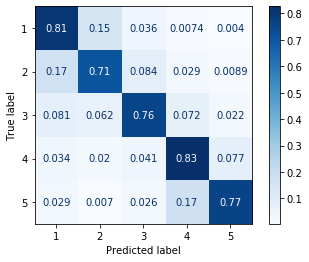


Validation Set
Accuracy: 0.549625

              precision    recall  f1-score   support

           1     0.6220    0.6988    0.6582      4867
           2     0.4694    0.4373    0.4527      4782
           3     0.4689    0.4516    0.4601      4867
           4     0.4832    0.5764    0.5257      4724
           5     0.7400    0.5836    0.6526      4760

    accuracy                         0.5496     24000
   macro avg     0.5567    0.5495    0.5499     24000
weighted avg     0.5566    0.5496    0.5499     24000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


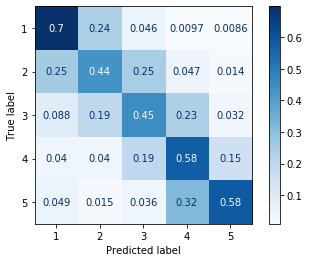


Testing Set
Accuracy: 0.5472

              precision    recall  f1-score   support

           1     0.6136    0.7037    0.6556      5883
           2     0.4807    0.4358    0.4572      6048
           3     0.4636    0.4500    0.4567      6009
           4     0.4825    0.5826    0.5278      6018
           5     0.7346    0.5677    0.6405      6042

    accuracy                         0.5472     30000
   macro avg     0.5550    0.5480    0.5475     30000
weighted avg     0.5548    0.5472    0.5471     30000



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


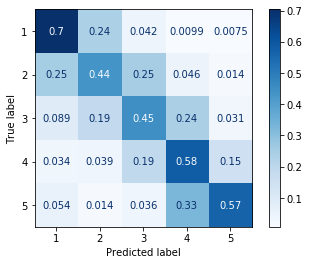


Contradictory Set
Accuracy: 0.4563106796116505

              precision    recall  f1-score   support

           1     0.4000    0.4000    0.4000        10
           2     0.5676    0.5250    0.5455        40
           3     0.4571    0.4103    0.4324        39
           4     0.2000    0.3333    0.2500         9
           5     0.5000    0.6000    0.5455         5

    accuracy                         0.4563       103
   macro avg     0.4249    0.4537    0.4347       103
weighted avg     0.4741    0.4563    0.4627       103



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


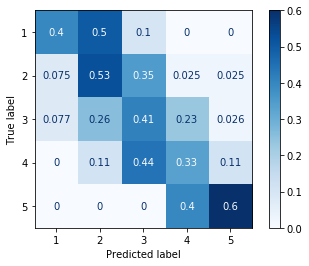


Figurative Set
Accuracy: 0.42592592592592593

              precision    recall  f1-score   support

           1     0.3333    0.3333    0.3333         6
           2     0.5556    0.5882    0.5714        17
           3     0.4286    0.3158    0.3636        19
           4     0.1818    0.3333    0.2353         6
           5     0.6000    0.5000    0.5455         6

    accuracy                         0.4259        54
   macro avg     0.4199    0.4141    0.4098        54
weighted avg     0.4496    0.4259    0.4316        54



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


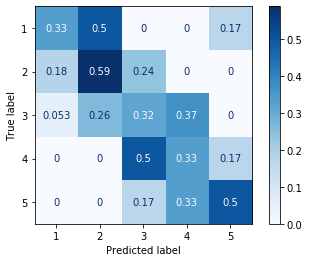


Qualifiers Set
Accuracy: 0.43243243243243246

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         1
           2     0.6154    0.5333    0.5714        15
           3     0.5000    0.3889    0.4375        18
           4     0.1111    1.0000    0.2000         1
           5     0.0000    0.0000    0.0000         2

    accuracy                         0.4324        37
   macro avg     0.2453    0.3844    0.2418        37
weighted avg     0.4957    0.4324    0.4499        37



C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\util

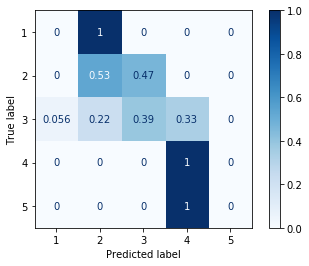

In [15]:
nb_model = evaluate_model(clf_nb, model_name="nb")

#### SVM

Fit and evaluate SVM classifier

In [68]:
clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=0.0001,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))
clf_sgd.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 5196.29, NNZs: 127532, Bias: -12.414873, T: 86400, Avg. loss: 1337.731063
Total training time: 0.08 seconds.
Norm: 6095.56, NNZs: 148225, Bias: -18.546891, T: 86400, Avg. loss: 2395.803664
Total training time: 0.09 seconds.
Norm: 6067.59, NNZs: 148552, Bias: -16.746176, T: 86400, Avg. loss: 2280.385773
Total training time: 0.09 seconds.
Norm: 5834.75, NNZs: 140126, Bias: -14.949101, T: 86400, Avg. loss: 2149.940887
Total training time: 0.09 seconds.
Norm: 5103.17, NNZs: 120564, Bias: -10.349570, T: 86400, Avg. loss: 1274.435222
Total training time: 0.09 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 2952.65, NNZs: 136720, Bias: -12.747622, T: 172800, Avg. loss: 96.391681
Total training time: 0.23 seconds.
Norm: 3497.31, NNZs: 155396, Bias: -17.348733, T: 172800, Avg. loss: 195.733734
Total training time: 0.22 seconds.
Norm: 3516.09, NNZs: 154498, Bias: -19.210756, T: 172800, Avg. loss: 201.607780
Total 

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', early_stopping=True,
                               n_jobs=-1, random_state=0, verbose=1))])

In [70]:
svm_mod = evaluate_model(clf_sgd, model_name="sgd")

Training Set
Accuracy: 0.94521875

              precision    recall  f1-score   support

           1     0.9596    0.9601    0.9599     19222
           2     0.9358    0.9392    0.9375     19184
           3     0.9358    0.9314    0.9336     19146
           4     0.9369    0.9380    0.9374     19259
           5     0.9580    0.9574    0.9577     19189

    accuracy                         0.9452     96000
   macro avg     0.9452    0.9452    0.9452     96000
weighted avg     0.9452    0.9452    0.9452     96000

Validation Set
Accuracy: 0.45866666666666667

              precision    recall  f1-score   support

           1     0.5896    0.6096    0.5995      4867
           2     0.3726    0.3841    0.3783      4782
           3     0.3522    0.3411    0.3466      4867
           4     0.3898    0.3918    0.3908      4724
           5     0.5884    0.5658    0.5768      4760

    accuracy                         0.4587     24000
   macro avg     0.4585    0.4585    0.4584     24

#### Edge Case Performance Analysis

In [45]:
#Perform random word removal 30 times and save accuracy scores for both baseline models to list
edge_naive = []*30
edge_svm = []*30
for i in range(30):
    x_contra, x_figurative, x_qual, y_contra, y_figurative, y_qual = short_extract(edge_features.copy(deep=True))   
    edge_naive.append(short_evaluate(clf_nb, model_name="nb"))
    edge_svm.append(short_evaluate(clf_sgd, model_name="sgd"))

Contradictory Set
Accuracy: 0.46601941747572817

              precision    recall  f1-score   support

           1     0.4286    0.6000    0.5000        10
           2     0.6071    0.4250    0.5000        40
           3     0.4750    0.4872    0.4810        39
           4     0.2308    0.3333    0.2727         9
           5     0.3750    0.6000    0.4615         5

    accuracy                         0.4660       103
   macro avg     0.4233    0.4891    0.4431       103
weighted avg     0.4956    0.4660    0.4711       103

Figurative Set
Accuracy: 0.46296296296296297

              precision    recall  f1-score   support

           1     0.4000    0.3333    0.3636         6
           2     0.5625    0.5294    0.5455        17
           3     0.6000    0.4737    0.5294        19
           4     0.2727    0.5000    0.3529         6
           5     0.2857    0.3333    0.3077         6

    accuracy                         0.4630        54
   macro avg     0.4242    0.4340   

C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Contradictory Set
Accuracy: 0.5145631067961165

              precision    recall  f1-score   support

           1     0.5000    0.5000    0.5000        10
           2     0.6286    0.5500    0.5867        40
           3     0.5385    0.5385    0.5385        39
           4     0.2500    0.3333    0.2857         9
           5     0.2857    0.4000    0.3333         5

    accuracy                         0.5146       103
   macro avg     0.4405    0.4644    0.4488       103
weighted avg     0.5322    0.5146    0.5214       103

Figurative Set
Accuracy: 0.5

              precision    recall  f1-score   support

           1     0.5000    0.5000    0.5000         6
           2     0.5882    0.5882    0.5882        17
           3     0.6000    0.4737    0.5294        19
           4     0.2727    0.5000    0.3529         6
           5     0.4000    0.3333    0.3636         6

    accuracy                         0.5000        54
   macro avg     0.4722    0.4791    0.4668        54

C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metr

Contradictory Set
Accuracy: 0.5631067961165048

              precision    recall  f1-score   support

           1     0.4444    0.4000    0.4211        10
           2     0.7222    0.6500    0.6842        40
           3     0.5714    0.5128    0.5405        39
           4     0.2941    0.5556    0.3846         9
           5     0.5000    0.6000    0.5455         5

    accuracy                         0.5631       103
   macro avg     0.5064    0.5437    0.5152       103
weighted avg     0.5900    0.5631    0.5713       103

Figurative Set
Accuracy: 0.5185185185185185

              precision    recall  f1-score   support

           1     0.5000    0.6667    0.5714         6
           2     0.6111    0.6471    0.6286        17
           3     0.7273    0.4211    0.5333        19
           4     0.2308    0.5000    0.3158         6
           5     0.5000    0.3333    0.4000         6

    accuracy                         0.5185        54
   macro avg     0.5138    0.5136    0

Contradictory Set
Accuracy: 0.4368932038834951

              precision    recall  f1-score   support

           1     0.3636    0.4000    0.3810        10
           2     0.6061    0.5000    0.5479        40
           3     0.4375    0.3590    0.3944        39
           4     0.2000    0.4444    0.2759         9
           5     0.4286    0.6000    0.5000         5

    accuracy                         0.4369       103
   macro avg     0.4072    0.4607    0.4198       103
weighted avg     0.4746    0.4369    0.4475       103

Figurative Set
Accuracy: 0.42592592592592593

              precision    recall  f1-score   support

           1     0.2500    0.1667    0.2000         6
           2     0.5000    0.5882    0.5405        17
           3     0.4615    0.3158    0.3750        19
           4     0.2727    0.5000    0.3529         6
           5     0.5000    0.5000    0.5000         6

    accuracy                         0.4259        54
   macro avg     0.3969    0.4141    

C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Contradictory Set
Accuracy: 0.5436893203883495

              precision    recall  f1-score   support

           1     0.4545    0.5000    0.4762        10
           2     0.6429    0.6750    0.6585        40
           3     0.5758    0.4872    0.5278        39
           4     0.2308    0.3333    0.2727         9
           5     0.5000    0.4000    0.4444         5

    accuracy                         0.5437       103
   macro avg     0.4808    0.4791    0.4759       103
weighted avg     0.5562    0.5437    0.5472       103

Figurative Set
Accuracy: 0.5555555555555556

              precision    recall  f1-score   support

           1     0.5714    0.6667    0.6154         6
           2     0.5882    0.5882    0.5882        17
           3     0.6667    0.5263    0.5882        19
           4     0.3333    0.5000    0.4000         6
           5     0.5000    0.5000    0.5000         6

    accuracy                         0.5556        54
   macro avg     0.5319    0.5562    0

C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Contradictory Set
Accuracy: 0.46601941747572817

              precision    recall  f1-score   support

           1     0.4444    0.4000    0.4211        10
           2     0.5455    0.4500    0.4932        40
           3     0.5128    0.5128    0.5128        39
           4     0.2667    0.4444    0.3333         9
           5     0.2857    0.4000    0.3333         5

    accuracy                         0.4660       103
   macro avg     0.4110    0.4415    0.4187       103
weighted avg     0.4863    0.4660    0.4719       103

Figurative Set
Accuracy: 0.42592592592592593

              precision    recall  f1-score   support

           1     0.4000    0.3333    0.3636         6
           2     0.5000    0.4706    0.4848        17
           3     0.5385    0.3684    0.4375        19
           4     0.2667    0.6667    0.3810         6
           5     0.4000    0.3333    0.3636         6

    accuracy                         0.4259        54
   macro avg     0.4210    0.4345   

Contradictory Set
Accuracy: 0.5242718446601942

              precision    recall  f1-score   support

           1     0.3636    0.4000    0.3810        10
           2     0.6571    0.5750    0.6133        40
           3     0.5714    0.5128    0.5405        39
           4     0.2353    0.4444    0.3077         9
           5     0.6000    0.6000    0.6000         5

    accuracy                         0.5243       103
   macro avg     0.4855    0.5065    0.4885       103
weighted avg     0.5566    0.5243    0.5359       103

Figurative Set
Accuracy: 0.5

              precision    recall  f1-score   support

           1     0.4000    0.3333    0.3636         6
           2     0.5556    0.5882    0.5714        17
           3     0.5714    0.4211    0.4848        19
           4     0.3333    0.6667    0.4444         6
           5     0.6000    0.5000    0.5455         6

    accuracy                         0.5000        54
   macro avg     0.4921    0.5019    0.4820        54

Contradictory Set
Accuracy: 0.4854368932038835

              precision    recall  f1-score   support

           1     0.4286    0.3000    0.3529        10
           2     0.5897    0.5750    0.5823        40
           3     0.5152    0.4359    0.4722        39
           4     0.2353    0.4444    0.3077         9
           5     0.4286    0.6000    0.5000         5

    accuracy                         0.4854       103
   macro avg     0.4395    0.4711    0.4430       103
weighted avg     0.5071    0.4854    0.4904       103

Figurative Set
Accuracy: 0.3888888888888889

              precision    recall  f1-score   support

           1     0.2500    0.1667    0.2000         6
           2     0.4211    0.4706    0.4444        17
           3     0.4706    0.4211    0.4444        19
           4     0.2000    0.3333    0.2500         6
           5     0.5000    0.3333    0.4000         6

    accuracy                         0.3889        54
   macro avg     0.3683    0.3450    0

C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Contradictory Set
Accuracy: 0.49514563106796117

              precision    recall  f1-score   support

           1     0.4545    0.5000    0.4762        10
           2     0.6667    0.5000    0.5714        40
           3     0.5000    0.4615    0.4800        39
           4     0.2222    0.4444    0.2963         9
           5     0.5000    0.8000    0.6154         5

    accuracy                         0.4951       103
   macro avg     0.4687    0.5412    0.4879       103
weighted avg     0.5360    0.4951    0.5057       103

Figurative Set
Accuracy: 0.4444444444444444

              precision    recall  f1-score   support

           1     0.5000    0.5000    0.5000         6
           2     0.6000    0.5294    0.5625        17
           3     0.4615    0.3158    0.3750        19
           4     0.1818    0.3333    0.2353         6
           5     0.4444    0.6667    0.5333         6

    accuracy                         0.4444        54
   macro avg     0.4376    0.4690    

C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Contradictory Set
Accuracy: 0.47572815533980584

              precision    recall  f1-score   support

           1     0.4167    0.5000    0.4545        10
           2     0.6333    0.4750    0.5429        40
           3     0.4872    0.4872    0.4872        39
           4     0.1429    0.2222    0.1739         9
           5     0.5000    0.8000    0.6154         5

    accuracy                         0.4757       103
   macro avg     0.4360    0.4969    0.4548       103
weighted avg     0.5076    0.4757    0.4845       103

Figurative Set
Accuracy: 0.5185185185185185

              precision    recall  f1-score   support

           1     0.5000    0.6667    0.5714         6
           2     0.6250    0.5882    0.6061        17
           3     0.6667    0.4211    0.5161        19
           4     0.1818    0.3333    0.2353         6
           5     0.5714    0.6667    0.6154         6

    accuracy                         0.5185        54
   macro avg     0.5090    0.5352    

C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Contradictory Set
Accuracy: 0.5339805825242718

              precision    recall  f1-score   support

           1     0.5556    0.5000    0.5263        10
           2     0.6757    0.6250    0.6494        40
           3     0.5588    0.4872    0.5205        39
           4     0.2353    0.4444    0.3077         9
           5     0.3333    0.4000    0.3636         5

    accuracy                         0.5340       103
   macro avg     0.4717    0.4913    0.4735       103
weighted avg     0.5647    0.5340    0.5449       103

Figurative Set
Accuracy: 0.48148148148148145

              precision    recall  f1-score   support

           1     0.4444    0.6667    0.5333         6
           2     0.6000    0.5294    0.5625        17
           3     0.6000    0.4737    0.5294        19
           4     0.2000    0.3333    0.2500         6
           5     0.4000    0.3333    0.3636         6

    accuracy                         0.4815        54
   macro avg     0.4489    0.4673    

C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Contradictory Set
Accuracy: 0.5436893203883495

              precision    recall  f1-score   support

           1     0.5000    0.4000    0.4444        10
           2     0.6250    0.6250    0.6250        40
           3     0.5588    0.4872    0.5205        39
           4     0.3333    0.5556    0.4167         9
           5     0.5000    0.6000    0.5455         5

    accuracy                         0.5437       103
   macro avg     0.5034    0.5335    0.5104       103
weighted avg     0.5563    0.5437    0.5459       103

Figurative Set
Accuracy: 0.46296296296296297

              precision    recall  f1-score   support

           1     0.2000    0.1667    0.1818         6
           2     0.5263    0.5882    0.5556        17
           3     0.6154    0.4211    0.5000        19
           4     0.2500    0.5000    0.3333         6
           5     0.6000    0.5000    0.5455         6

    accuracy                         0.4630        54
   macro avg     0.4383    0.4352    

Contradictory Set
Accuracy: 0.5728155339805825

              precision    recall  f1-score   support

           1     0.4167    0.5000    0.4545        10
           2     0.7222    0.6500    0.6842        40
           3     0.6250    0.5128    0.5634        39
           4     0.2941    0.5556    0.3846         9
           5     0.5000    0.6000    0.5455         5

    accuracy                         0.5728       103
   macro avg     0.5116    0.5637    0.5264       103
weighted avg     0.6075    0.5728    0.5832       103

Figurative Set
Accuracy: 0.5555555555555556

              precision    recall  f1-score   support

           1     0.5714    0.6667    0.6154         6
           2     0.6875    0.6471    0.6667        17
           3     0.6000    0.4737    0.5294        19
           4     0.2727    0.5000    0.3529         6
           5     0.6000    0.5000    0.5455         6

    accuracy                         0.5556        54
   macro avg     0.5463    0.5575    0

Contradictory Set
Accuracy: 0.47572815533980584

              precision    recall  f1-score   support

           1     0.4545    0.5000    0.4762        10
           2     0.5833    0.5250    0.5526        40
           3     0.5143    0.4615    0.4865        39
           4     0.1429    0.2222    0.1739         9
           5     0.4286    0.6000    0.5000         5

    accuracy                         0.4757       103
   macro avg     0.4247    0.4618    0.4378       103
weighted avg     0.4987    0.4757    0.4845       103

Figurative Set
Accuracy: 0.5

              precision    recall  f1-score   support

           1     0.6667    0.6667    0.6667         6
           2     0.6000    0.5294    0.5625        17
           3     0.4375    0.3684    0.4000        19
           4     0.3000    0.5000    0.3750         6
           5     0.5714    0.6667    0.6154         6

    accuracy                         0.5000        54
   macro avg     0.5151    0.5462    0.5239        5

C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\owltu\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
edge_naive = np.array(edge_naive)
edge_svm = np.array(edge_svm)

In [58]:
from scipy import stats

Analysis on linguistic features -- order of results is contradictory, figurative, qualifier

In [66]:
print(stats.describe(edge_naive[:,0]), stats.describe(edge_naive[:,1]), stats.describe(edge_naive[:,2]), sep="\n")

DescribeResult(nobs=30, minmax=(0.42718446601941745, 0.5825242718446602), mean=0.5016181229773463, variance=0.0015688262947421558, skewness=0.2509153961943282, kurtosis=-0.6919202710539962)
DescribeResult(nobs=30, minmax=(0.35185185185185186, 0.5555555555555556), mean=0.47098765432098766, variance=0.0024285353893697876, skewness=-0.15338630892875782, kurtosis=-0.27608008352196123)
DescribeResult(nobs=30, minmax=(0.4594594594594595, 0.6756756756756757), mean=0.555855855855856, variance=0.00340965382903873, skewness=0.09535100554120558, kurtosis=-0.6834596583340198)


In [67]:
print(stats.describe(edge_svm[:,0]), stats.describe(edge_svm[:,1]), stats.describe(edge_svm[:,2]), sep = "\n")

DescribeResult(nobs=30, minmax=(0.34951456310679613, 0.5242718446601942), mean=0.42038834951456305, variance=0.001645642444118689, skewness=0.4858404268543575, kurtosis=-0.03174358211948958)
DescribeResult(nobs=30, minmax=(0.42592592592592593, 0.6111111111111112), mean=0.5074074074074074, variance=0.0017643441653658772, skewness=0.6462888211907749, kurtosis=0.46342602908092356)
DescribeResult(nobs=30, minmax=(0.32432432432432434, 0.6216216216216216), mean=0.44054054054054054, variance=0.004239187929775067, skewness=0.6791329387217189, kurtosis=0.38819780059163644)
